In [ ]:
from dolfinx import fem, io, mesh, plot, nls, log
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import dolfinx
print(f"Using dolfinx version: {dolfinx.__version__}")

import numpy as np
import sys
import os
import re
import cv2
import trimesh
import tetgen 
import time
import gmsh
import meshio 
import math
import shutil
import json

import matplotlib.pyplot as plt
import SimpleITK as sitk
import pymeshfix as pfix
import pyvista as pv
import skimage.morphology as skm
import iso2mesh as i2m
import pygalmesh as pygm
import pymeshlab as ml
import triangle as tr

from iso2mesh import plotmesh
from scipy import ndimage as ndi
from scipy.spatial import cKDTree
from skimage import io as skio
from skimage.filters import threshold_otsu
from tqdm.notebook import tqdm
from skimage.transform import resize
from typing import Any, Dict, Optional, Tuple, List

sys.path.append('./src')  # to import alveoRVE from parent directory

from alveoRVE.plot.mpl import show_four_panel_volume
from alveoRVE.plot.pv import view_surface

%load_ext autoreload
%autoreload 2

Using dolfinx version: 0.9.0


In [2]:
def matlab_to_python_conv(no, fc): 
    no_out = no[:, :3].copy()
    fc_out = (np.atleast_2d(fc).astype(np.int64)[:, :3] - 1).astype(np.int32)
    return no_out, fc_out

# Global configs

In [3]:
ct_folder         = "/mnt/c/Users/bherr/Downloads/CT-1um/images_reconstructed_1um"
e8_folder         = "/mnt/c/Users/bherr/Downloads/E8-1um/images_reconstructed_1um"
border_px      = 0
resize_factor  = 1.5
offset_xyz     = (1,1,1)
thr_binary     = 0.5

# CT generation

In [ ]:
files = [f for f in os.listdir(ct_folder) if f.lower().endswith(".bmp")]
# numeric sort by the largest integer in filename
def key(f): 
    m = re.findall(r"\\d+", f)
    return int(m[-1]) if m else -1
paths = [os.path.join(ct_folder, f) for f in sorted(files, key=key)]

z = len(paths)
y, x = skio.imread(paths[0], as_gray=True).shape
print(f"Image size: {x} x {y} x {z}")

volume_shape = [y, x, z]

Image size: 4012 x 4000 x 2510


In [5]:
## snapshot of 0%, 20%, 40%, 60%, 80%, 100% of the stack
# fig, ax = plt.subplots(1, 6, figsize=(15, 5))
# for i, perc in enumerate([0, 0.2, 0.4, 0.6, 0.8, 1.0]):
#     idx = int((z-1) * perc)
#     img = cv2.imread(paths[idx], cv2.IMREAD_UNCHANGED).astype(np.float32)
#     ax[i].imshow(img, cmap='gray')
#     ax[i].set_title(f"Slice {idx}")
#     ax[i].axis('off')
# plt.tight_layout()
# plt.show()

curr_folder: /home/bnherrerac/CHASKi/alveoRVE/results/CT/rves/80um/1852_3531_1237


Reading BMP stack:   0%|          | 0/80 [00:00<?, ?it/s]

[read_bmp_stack] First image shape: (80, 80), min/max: 0.0/254.0


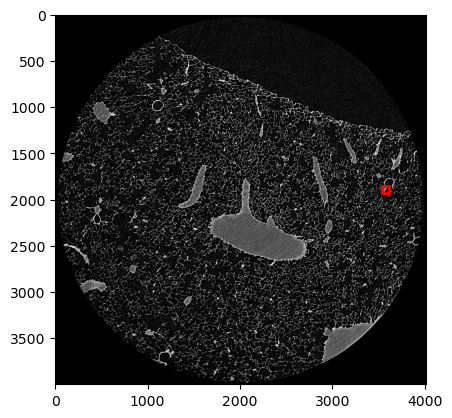

[read_bmp_stack] Final volume shape: (80, 80, 80)
[read_bmp_stack] Volume min/max: 0.0/254.0
[read_bmp_stack] Volume min/max after normalization: 0.0/1.0
Porosity (thr=0.098): 56.53%
porosity original: 0.7969
[resize] new porosity: 0.7963
[resize] new shape: (160, 160, 160)
starting filtering pipeline
denoised with Curvature Anisotropic Diffusion, time: 3.21 s
thresholded to remove low-valued pixels, time: 0.00 s
contrast enhanced with Adaptive Histogram Equalization, time: 3.71 s
thresholded to binary image, time: 10.56 s
converted to NumPy array, time: 0.00 s
removed small objects, time: 0.04 s
thinned slice-by-slice, time: 0.12 s
removed small objects after thinning, time: 0.04 s
removed small holes, time: 0.04 s
final porosity segmented: 0.7194
curr_folder: /home/bnherrerac/CHASKi/alveoRVE/results/CT/rves/80um/611_2184_124


Reading BMP stack:   0%|          | 0/80 [00:00<?, ?it/s]

[read_bmp_stack] First image shape: (80, 80), min/max: 0.0/229.0


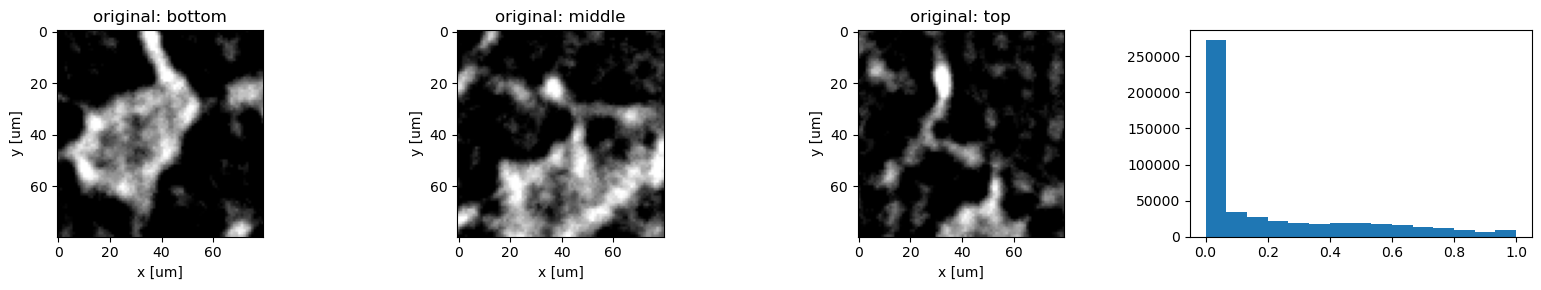

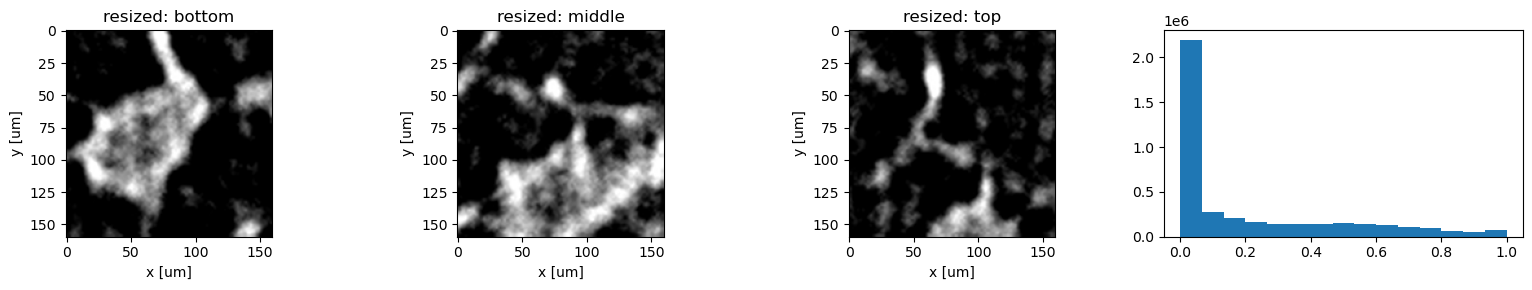

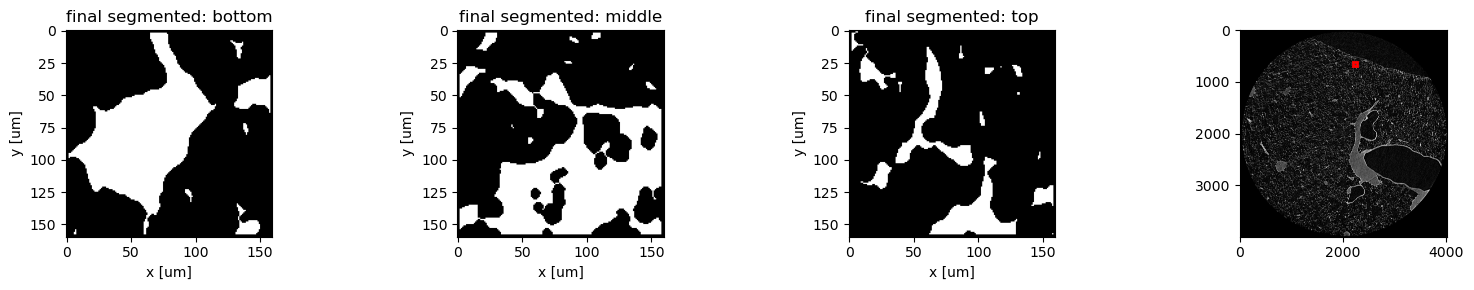

[read_bmp_stack] Final volume shape: (80, 80, 80)
[read_bmp_stack] Volume min/max: 0.0/254.0
[read_bmp_stack] Volume min/max after normalization: 0.0/1.0
Porosity (thr=0.098): 67.29%
porosity original: 0.8958
[resize] new porosity: 0.8953
[resize] new shape: (160, 160, 160)
starting filtering pipeline
denoised with Curvature Anisotropic Diffusion, time: 3.19 s
thresholded to remove low-valued pixels, time: 0.00 s
contrast enhanced with Adaptive Histogram Equalization, time: 2.88 s
thresholded to binary image, time: 10.43 s
converted to NumPy array, time: 0.00 s
removed small objects, time: 0.04 s
thinned slice-by-slice, time: 0.12 s
removed small objects after thinning, time: 0.04 s
removed small holes, time: 0.04 s
final porosity segmented: 0.8219
curr_folder: /home/bnherrerac/CHASKi/alveoRVE/results/CT/rves/80um/2987_2839_160


Reading BMP stack:   0%|          | 0/80 [00:00<?, ?it/s]

[read_bmp_stack] First image shape: (80, 80), min/max: 0.0/254.0


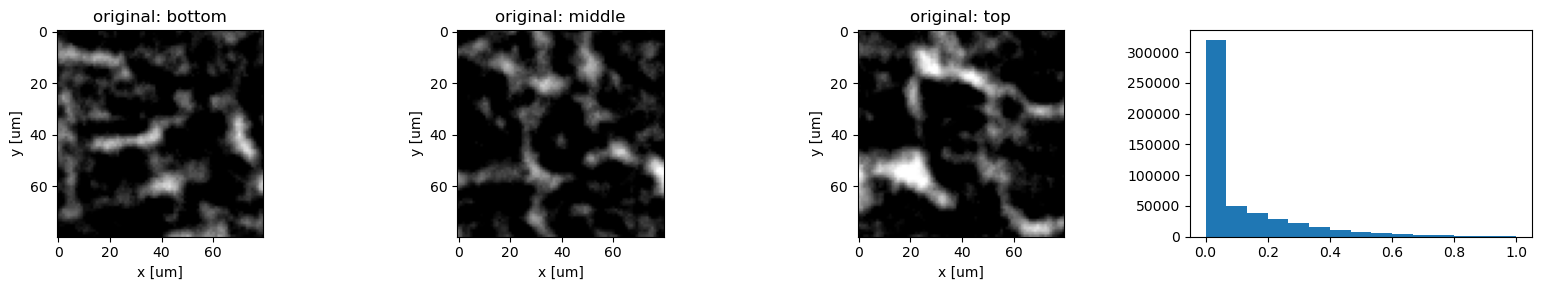

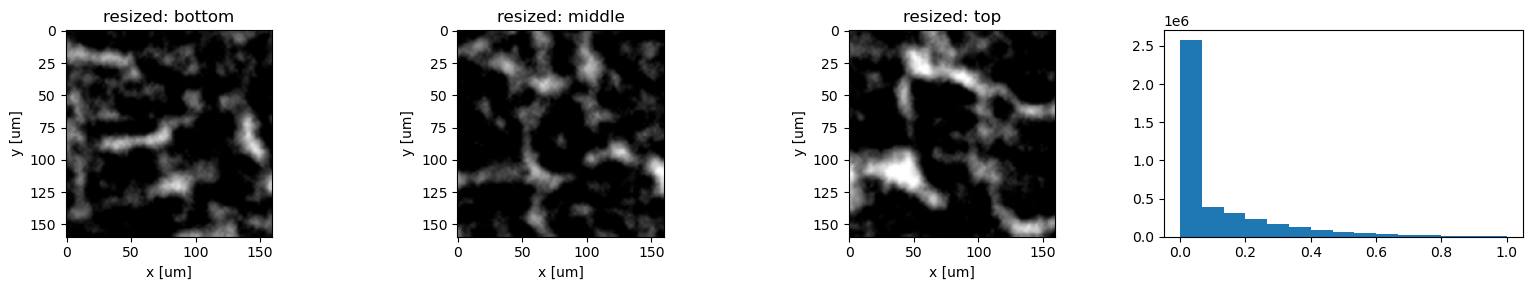

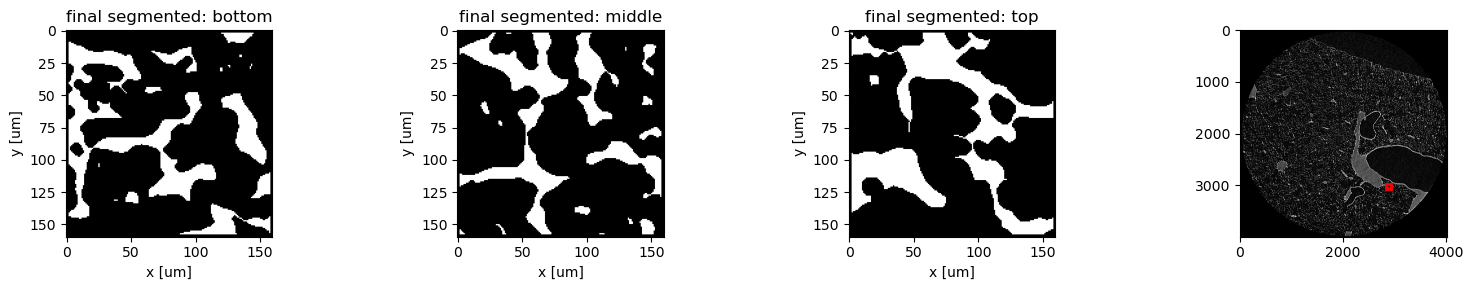

[read_bmp_stack] Final volume shape: (80, 80, 80)
[read_bmp_stack] Volume min/max: 0.0/254.0
[read_bmp_stack] Volume min/max after normalization: 0.0/1.0
Porosity (thr=0.098): 46.58%
porosity original: 0.7638
[resize] new porosity: 0.7633
[resize] new shape: (160, 160, 160)
starting filtering pipeline
denoised with Curvature Anisotropic Diffusion, time: 3.21 s
thresholded to remove low-valued pixels, time: 0.00 s
contrast enhanced with Adaptive Histogram Equalization, time: 4.91 s
thresholded to binary image, time: 10.40 s
converted to NumPy array, time: 0.00 s
removed small objects, time: 0.04 s
thinned slice-by-slice, time: 0.12 s
removed small objects after thinning, time: 0.04 s
removed small holes, time: 0.04 s
final porosity segmented: 0.6862


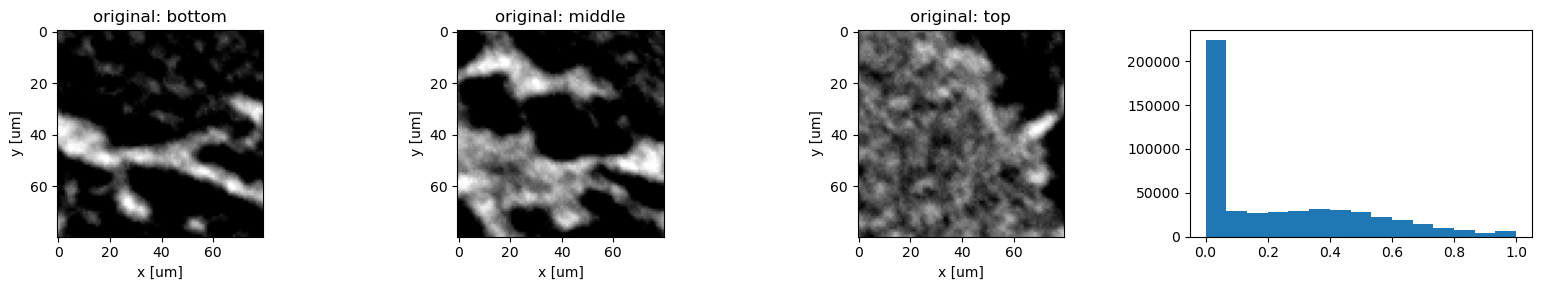

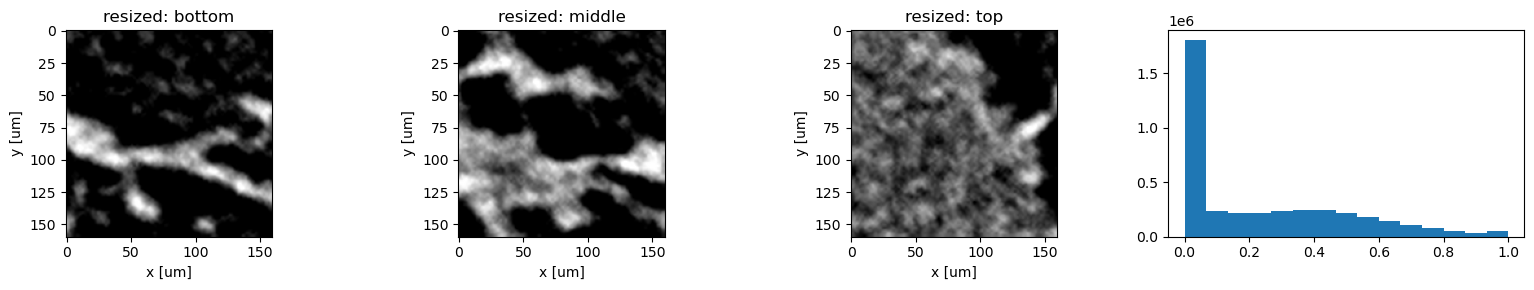

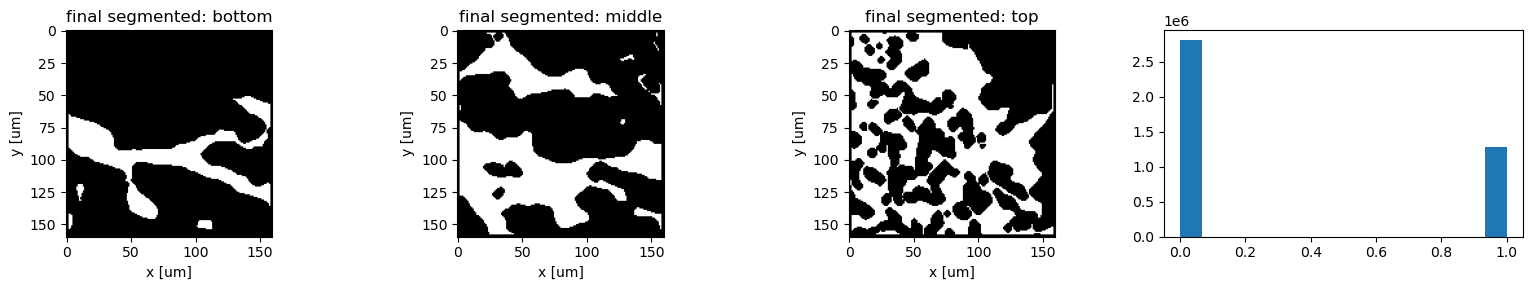

In [ ]:
        for i, p in enumerate(tqdm(paths[sample[2]:sample[2]+size_rve], desc="Reading BMP stack")):
            img = cv2.imread(p, cv2.IMREAD_UNCHANGED)[sample[1]:sample[1]+size_rve, sample[0]:sample[0]+size_rve].astype(np.float32)
            if i == 0: 
                full_img = cv2.imread(p, cv2.IMREAD_UNCHANGED).astype(np.float32)
                print(f"[read_bmp_stack] First image shape: {img.shape}, min/max: {img.min()}/{img.max()}")
                plt.imshow(full_img, cmap='gray')
                # add red rectangle to show RVE location
                plt.gca().add_patch(plt.Rectangle((sample[1], sample[0]), size_rve, size_rve, edgecolor='red', facecolor='none', lw=2))
                plt.show()
            imgs.append(img)
        vol = np.stack(imgs)
        print(f"[read_bmp_stack] Final volume shape: {vol.shape}")
        print(f"[read_bmp_stack] Volume min/max: {vol.min()}/{vol.max()}")
        if vol.max() == 0:
            print("[read_bmp_stack] WARNING: volume is all zeros, skipping this RVE")
            continue
        vol /= vol.max()
        print(f"[read_bmp_stack] Volume min/max after normalization: {vol.min()}/{vol.max()}")
        if np.isnan(vol).any():
            print("[read_bmp_stack] WARNING: NaNs in volume after normalization, skipping this RVE")
            continue

In [7]:
def _to_pv_polydata(tm: trimesh.Trimesh) -> pv.PolyData:
    """Trimesh -> PyVista PolyData (faces in VTK cell array format)."""
    pts = np.asarray(tm.vertices, dtype=float)
    tri = np.asarray(tm.faces,    dtype=np.int64)
    if tri.ndim != 2 or tri.shape[1] != 3:
        raise ValueError("Expected triangular faces Nx3")
    cells = np.empty((tri.shape[0], 4), dtype=np.int64)
    cells[:, 0] = 3
    cells[:, 1:] = tri
    cells = cells.ravel()
    pd = pv.PolyData(pts, cells)
    return pd

def _from_pv_polydata(pd: pv.PolyData) -> trimesh.Trimesh:
    """PyVista PolyData -> Trimesh (triangles)."""
    # ensure triangles
    if not pd.is_all_triangles:
        pd = pd.triangulate()
    faces_vtk = np.asarray(pd.faces, dtype=np.int64)
    if faces_vtk.size == 0:
        return trimesh.Trimesh(vertices=np.asarray(pd.points, float), faces=np.empty((0,3), int), process=False)
    faces = faces_vtk.reshape(-1, 4)[:, 1:].astype(np.int32, copy=False)
    verts = np.asarray(pd.points, dtype=float)
    return trimesh.Trimesh(vertices=verts, faces=faces, process=False)

def vtk_weld_two(triA: trimesh.Trimesh, triB: trimesh.Trimesh, tol: float = 5e-9) -> trimesh.Trimesh:
    """Append two touching shells and weld coincident seam vertices with absolute tolerance."""
    pa = _to_pv_polydata(triA)
    pb = _to_pv_polydata(triB)

    print(f"[pv] A: V={pa.n_points:,} F={pa.n_cells:,} | B: V={pb.n_points:,} F={pb.n_cells:,}")
    p = pa + pb  # vtkAppendPolyData
    print(f"[pv] appended: V={p.n_points:,} F={p.n_cells:,}")

    # clean: absolute tolerance; merge coincident points; drop duplicate cells
    p = p.clean(tolerance=tol, absolute=True, point_merging=True)
    print(f"[pv] after clean: V={p.n_points:,} F={p.n_cells:,}")

    # ensure triangles and drop duplicates again just in case
    p = p.triangulate()
    print(f"[pv] after triangulate+dedup: V={p.n_points:,} F={p.n_cells:,}")

    tm = _from_pv_polydata(p)
    print(f"[pv] back to trimesh: V={len(tm.vertices):,} F={len(tm.faces):,} | watertight={tm.is_watertight}")
    return tm

AXIS_ID = {'x':0,'y':1,'z':2}

def _axis_pair(ax:str):
    a = AXIS_ID[ax]
    t = [0,1,2]; t.remove(a)
    return a, t[0], t[1]

def preview_periodic_pairs(V:np.ndarray, axis:str, tol:float=1e-6):
    a,t1,t2 = _axis_pair(axis)
    Smin = np.where(np.isclose(V[:,a], 0.0, atol=tol))[0]
    Smax = np.where(np.isclose(V[:,a], 1.0, atol=tol))[0]
    kd = cKDTree(V[Smax][:,[t1,t2]])
    d,j = kd.query(V[Smin][:,[t1,t2]], distance_upper_bound=max(tol, 10*tol))
    ok = np.isfinite(d)
    n_ok = int(np.sum(ok)); n_tot = len(Smin)
    print(f"[pairs {axis}] matched {n_ok}/{n_tot} within tol={tol:g}")

    if n_ok < n_tot:
        print(f"[pairs {axis}] WARNING: some vertices on min/max planes could not be matched within tol={tol:g}")

    return Smin[ok], Smax[j[ok]], n_ok, n_tot


def area_of_flat_faces(V: np.ndarray, F: np.ndarray, axis: str, plane_value: float, tol: float = 1e-9) -> float:
    ax = AXIS_ID[axis]
    oth = [i for i in range(3) if i != ax]

    # Select faces that have all three vertices on the plane
    face_mask = np.all(np.isclose(V[F][:, :, ax], plane_value, atol=tol), axis=1)
    F_plane = F[face_mask]

    if len(F_plane) == 0:
        print(f"No faces found on the {axis}={plane_value} plane within tol={tol}")
        return 0.0

    # Calculate area of these faces
    p0, p1, p2 = V[F_plane][:, 0], V[F_plane][:, 1], V[F_plane][:, 2]
    A = 0.5 * np.linalg.norm(np.cross(p1 - p0, p2 - p0), axis=1)
    total_area = float(np.sum(A))

    print(f"Total area of faces on the {axis}={plane_value} plane: {total_area:.6g} (from {len(F_plane)} faces)")
    return total_area


In [ ]:
def remove_duplicate_faces(no: np.ndarray, fc: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Remove duplicate faces from the mesh.

    Parameters:
    no (np.ndarray): Array of node coordinates.
    fc (np.ndarray): Array of face indices.

    Returns:
    Tuple[np.ndarray, np.ndarray]: Tuple containing the updated node coordinates and face indices.
    """
    # Sort each face's vertex indices to ensure consistent ordering
    sorted_fc = np.sort(fc, axis=1)
    
    # Find unique faces and their indices
    unique_faces, unique_indices = np.unique(sorted_fc, axis=0, return_index=True)
    
    # Select only the unique faces
    fc_unique = fc[unique_indices]

    print(f"original number of faces: {fc.shape[0]}, unique faces: {fc_unique.shape[0]}")
    
    return fc_unique

# Utility: robust JSON saver handling numpy types

def _to_jsonable(obj):
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if isinstance(obj, (np.bool_,)):
        return bool(obj)
    return obj


def save_json(path: str, data: dict):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as f:
        json.dump(data, f, indent=2, sort_keys=True, default=_to_jsonable)


def _triangle_quality(V, F):
    # 2*sqrt(3)*A / sum(l^2)  -> 1 for equilateral; 0 for degenerate
    p0, p1, p2 = V[F[:,0]], V[F[:,1]], V[F[:,2]]
    e0 = np.linalg.norm(p1 - p0, axis=1)
    e1 = np.linalg.norm(p2 - p1, axis=1)
    e2 = np.linalg.norm(p0 - p2, axis=1)
    A  = 0.5*np.linalg.norm(np.cross(p1 - p0, p2 - p0), axis=1)
    denom = e0**2 + e1**2 + e2**2
    with np.errstate(divide='ignore', invalid='ignore'):
        q = (2.0*math.sqrt(3.0))*A/denom
        q[~np.isfinite(q)] = 0.0
    return np.clip(q, 0.0, 1.0)


def mesh_report(mesh: trimesh.Trimesh, name="mesh", plot=True, tol_dup=1e-12) -> dict:
    """
    Print thorough stats and return a dict. Does NOT mutate the mesh.
    """
    m = mesh.copy()

    print(f"\n=== {name}: geometric/graph checks START ===")
    print(f"trimesh metrics:")
    print(f"mesh is_winding_consistent? {m.is_winding_consistent}")
    print(f"mesh is_watertight? {m.is_watertight}")
    print(f"verts={len(m.vertices):,}, faces={len(m.faces):,}")
    bbox = m.bounds
    L = bbox[1] - bbox[0]
    print(f"bbox min={bbox[0]}, max={bbox[1]}, extents={L}")

    # basic areas/volumes
    A = float(m.area)
    Vvol = float(m.volume) if m.is_watertight else None
    print(f"surface area = {A:.6g}")
    if Vvol is not None:
        print(f"enclosed volume (watertight) = {Vvol:.6g}")
    else:
        print("enclosed volume = N/A (mesh not watertight)")

    # edge-length stats (proxy for 'h')
    edges = m.edges_unique
    elen  = np.linalg.norm(m.vertices[edges[:,0]] - m.vertices[edges[:,1]], axis=1)
    print(f"h (edge length): min={elen.min():.4g}, mean={elen.mean():.4g}, max={elen.max():.4g}")

    # duplicates (faces & vertices)
    F_sorted = np.sort(m.faces, axis=1)
    _, idx = np.unique(F_sorted, axis=0, return_index=True)
    dup_faces = len(m.faces) - len(idx)
    Vkey = np.round(m.vertices / tol_dup).astype(np.int64)
    _, vidx = np.unique(Vkey, axis=0, return_index=True)
    dup_verts = len(m.vertices) - len(vidx)
    print(f"duplicate faces: {dup_faces:,}, duplicate vertices (<= {tol_dup:g}): {dup_verts:,}")

    V, F = m.vertices.copy(), m.faces.copy()

    print(f"== pymeshlab metrics:")

    ms = ml.MeshSet()
    ms.add_mesh(ml.Mesh(V, F))

    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()
    print("Geometric measures:")
    for k, v in geo_measures.items():
        if k in ['surface_area', 'avg_edge_length', 'volume']:
            v = float(v)
            print(f"  {k}: {v}")
    print("Topological measures:")
    for k, v in topo_measures.items():
        if k in ['non_two_manifold_edges', 'boundary_edges', 'non_two_manifold_vertices', 'genus', 'faces_number', 'vertices_number', 'edges_number', 'connected_components_number']:
            v = int(v)
            print(f"  {k}: {v}")
    print(f"== custom metrics:")
    # triangle quality
    q = _triangle_quality(m.vertices, m.faces)
    q_stats = dict(min=float(q.min()), p5=float(np.percentile(q,5)),
                   mean=float(q.mean()), p95=float(np.percentile(q,95)),
                   max=float(q.max()))
    print(f"triangle quality q in [0,1] (equilateral=1): "
          f"min={q_stats['min']:.3f}, p5={q_stats['p5']:.3f}, "
          f"mean={q_stats['mean']:.3f}, p95={q_stats['p95']:.3f}, max={q_stats['max']:.3f}")


    if plot:
        plt.figure(figsize=(5,3))
        plt.hist(q, bins=40, range=(0,1), alpha=0.8)
        plt.xlabel("triangle quality q"); plt.ylabel("count"); plt.title(f"Quality histogram: {name}")
        plt.tight_layout(); plt.show()

    return dict(
        verts=len(m.vertices), faces=len(m.faces),
        area=A, volume=Vvol, bbox=bbox, h_stats=(float(elen.min()), float(elen.mean()), float(elen.max())),
        watertight=bool(m.is_watertight),
        dup_faces=int(dup_faces), dup_verts=int(dup_verts),
        tri_quality=q_stats
    )


def quick_mesh_report(ms: ml.MeshSet | trimesh.Trimesh, i: int = 0):
    # print(f"\n == pymeshlab quick metrics:")
    # number of vertices and faces

    flag = False
    if isinstance(ms, trimesh.Trimesh):
        flag = True
        V, F = ms.vertices, ms.faces
        ms = ml.MeshSet()
        ms.add_mesh(ml.Mesh(V, F))
    else: 
        V = ms.current_mesh().vertex_matrix()
        F = ms.current_mesh().face_matrix()

    n_verts = ms.current_mesh().vertex_number()
    n_faces = ms.current_mesh().face_number()
    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()
    h = geo_measures['avg_edge_length']

    connected_components = topo_measures['connected_components_number']

    # trimesh watertightness
    trimesh_mesh = trimesh.Trimesh(
        vertices=np.asarray(ms.current_mesh().vertex_matrix(), float),
        faces=np.asarray(ms.current_mesh().face_matrix(), int),
        process=False
    )
    is_watertight = trimesh_mesh.is_watertight
    is_winding_consistent = trimesh_mesh.is_winding_consistent

    # trimesh volume
    vol = trimesh_mesh.volume if is_watertight else None
    area = trimesh_mesh.area

    # pymeshlab nonmanifold edges/faces
    n_nonmanifold_edges = int(topo_measures['non_two_manifold_edges'])
    n_nonmanifold_vertices = int(topo_measures['non_two_manifold_vertices'])

    print(f"[quick {i} 1/3] {n_verts} verts, {n_faces} faces, watertight: {is_watertight}, genus: {topo_measures['genus']}, wind-consistent: {is_winding_consistent}, h = {np.round(h, 3)}, components: {connected_components}\n[quick {i} 2/3] vol = {vol}, area = {area}, non-manifold edges: {n_nonmanifold_edges}/ vertices: {n_nonmanifold_vertices}\n[quick {i} 3/3] bbox: {V.min(axis=0)} to {V.max(axis=0)}")

    if flag: 
        del ms

    return {
        "n_verts": n_verts,
        "n_faces": n_faces,
        "is_watertight": is_watertight,
        "is_winding_consistent": is_winding_consistent,
        "h": h,
        "connected_components": connected_components,
        "vol": vol,
        "area": area,
        "n_nonmanifold_edges": n_nonmanifold_edges,
        "n_nonmanifold_vertices": n_nonmanifold_vertices
    }


def heal(ms: ml.MeshSet, manifold_method = 0):
    i = 0
    print("[REMOVING DUPLICATE VERTICES]")
    ms.meshing_remove_duplicate_vertices()
    
    #i+1; quick_mesh_report(ms, i)
    print("[REMOVING DUPLICATE FACES]")
    ms.meshing_remove_duplicate_faces()
    #i+1; quick_mesh_report(ms, i)
    print("[REMOVING NULL FACES]")
    ms.meshing_remove_null_faces()
    #i+1; quick_mesh_report(ms, i)
    print("[REMOVING UNREFERENCED VERTICES]")
    ms.meshing_remove_unreferenced_vertices()
    #i+1; quick_mesh_report(ms, i)
    # NOTE: Intentionally do NOT remove T vertices as per user request
    # ms.meshing_remove_t_vertices()  # (kept disabled)
    # i+1; quick_mesh_report(ms, i)
    print(f"[REPAIRING NON-MANIFOLD EDGES with manifold_method = {manifold_method}]")
    ms.meshing_repair_non_manifold_edges(method=manifold_method)
    #i+1; quick_mesh_report(ms, i)
    print("[REPAIRING NON-MANIFOLD VERTICES]")
    ms.meshing_repair_non_manifold_vertices()
    #i+1; quick_mesh_report(ms, i)
    print("[REMOVING NULL FACES AGAIN]")
    ms.meshing_remove_null_faces()
    # i+1; quick_mesh_report(ms, i)
    print("[REMOVING UNREFERENCED VERTICES AGAIN]")
    ms.meshing_remove_unreferenced_vertices()
    # i+1; quick_mesh_report(ms, i)
    print(f"[REPAIRING NON-MANIFOLD EDGES AGAINx2 with manifold_method = {1-manifold_method}]")
    ms.meshing_repair_non_manifold_edges(method=1-manifold_method)
    # i+1; quick_mesh_report(ms, i)
    print("[REPAIRING NON-MANIFOLD VERTICES AGAINx2]")
    ms.meshing_repair_non_manifold_vertices()
    # i+1; quick_mesh_report(ms, i)
    print("[REMOVING NULL FACES AGAINx2]")
    ms.meshing_remove_null_faces()
    # i+1; quick_mesh_report(ms, i)
    print("[REMOVING UNREFERENCED VERTICES AGAINx2]")
    ms.meshing_remove_unreferenced_vertices()
    i+1; quick_mesh_report(ms, i)

    if trimesh.Trimesh(
        vertices=np.asarray(ms.current_mesh().vertex_matrix(), float),
        faces=np.asarray(ms.current_mesh().face_matrix(), int),
        process=False
    ).volume < 0:
        ms.meshing_invert_face_orientation()

    # geo_measures = ms.get_geometric_measures()
    # topo_measures = ms.get_topological_measures()
    # print("\nGeometric measures:")
    # for k, v in geo_measures.items():
    #     print(f"  {k}: {v}")
    # print("\nTopological measures:")
    # for k, v in topo_measures.items():
    #     print(f"  {k}: {v}")


def remove_close_verts(ms: ml.MeshSet, tol=1e-5):
    print(f"Removing close vertices with tol={tol}")
    initial_v = ms.current_mesh().vertex_number()
    ms.meshing_merge_close_vertices(threshold = ml.PercentageValue(tol*100))
    final_v = ms.current_mesh().vertex_number()
    print(f" - removed {initial_v - final_v} vertices")


def print_python_or_matlab_indexing(fc, name=""): 
    if np.min(fc) == 0:
        print(f" - {name} (python)")
    elif np.min(fc) == 1:
        print(f" - {name} (matlab)")
    else:
        print(f" - {name} (unknown indexing)")


def normalize_vertices_inplace(no):
    no[:, :3] = (no[:, :3] - no[:, :3].min(axis=0)) / (no[:, :3].max(axis=0) - no[:, :3].min(axis=0))


def normalize_vertices(no): 
    no_out = no.copy()
    no_out[:, :3] = (no_out[:, :3] - no_out[:, :3].min(axis=0)) / (no_out[:, :3].max(axis=0) - no_out[:, :3].min(axis=0))
    return no_out


def view_wireframe(V: np.ndarray, F: np.ndarray, title="surface"):
    faces = np.hstack([np.full((len(F),1),3), F]).ravel()
    mesh = pv.PolyData(V, faces)
    p = pv.Plotter()
    p.add_mesh(mesh, show_edges=True, color='black', style='wireframe')
    p.add_axes(); p.show(title=title)


def view_cropped(V, F, title, point_on_plane=None, normal=None, mode="wireframe"):
    # default is half the model
    if point_on_plane is None:
        point_on_plane = V.mean(axis=1)
    if normal is None:
        normal = np.array([0,0,1])
    faces = np.hstack([np.full((len(F),1),3), F]).ravel()
    mesh = pv.PolyData(V, faces)
    clipped = mesh.clip(normal=normal, origin=point_on_plane, invert=False)
    p = pv.Plotter()
    p.add_mesh(clipped, show_edges=True, style="wireframe" if mode=="wireframe" else "surface")
    p.add_axes(); p.show(title=title)

: 

In [ ]:
radbound = 2.0
opts = {"radbound": float(radbound)}    
completed_meshes = 0

for i, bin_path in enumerate(RVEs_binary_paths):
    out_folder_name = os.path.dirname(bin_path)
    print("\n================ RVE PIPELINE START ================")
    print(f"Processing RVE {i+1}/{len(RVEs_binary_paths)}: {bin_path}")
    data = np.load(bin_path)
    img_segmented = data['vol']
    print(f"Segmented volume shape: {img_segmented.shape}, min/max: {img_segmented.min()}/{img_segmented.max()}")
    print(f"Segmented volume porosity: {1.0 - (np.sum(img_segmented) / img_segmented.size):.4f}")

    print("---------------- Surface meshing (iso2mesh) ----------------")
    ## generate mesh with iso2mesh
    no, el, fc = i2m.v2m(img_segmented, 0.5, opts, 1e12, "cgalmesh")
    print(no.shape, fc.shape)
    fc_unique = remove_duplicate_faces(no, fc)
    print(f"fc_unique shape: {fc_unique.shape}")
    stl_temp_path = os.path.join(out_folder_name, "triang_after_dedup.stl")
    i2m.savestl(*matlab_to_python_conv(no, fc_unique), stl_temp_path)

    ## read mesh
    mesh = meshio.read(stl_temp_path)
    nodes = mesh.points
    cells_dict = mesh.cells_dict
    print(f"cells_dict: {cells_dict}")
    elems = mesh.cells_dict['triangle']
    print(nodes.shape)
    print(elems.shape)

    print("---------------- Initial clean (PyMeshFix) ----------------")
    ## pymeshfix 
    clean_nodes, clean_elems = pfix.clean_from_arrays(nodes, elems)
    print(f"cleaned\nold shapes: nodes {nodes.shape}, elems {elems.shape}\nnew shapes: clean_nodes {clean_nodes.shape}, clean_elems {clean_elems.shape}")
    # Checks whether original mesh was already clean
    print(np.array_equal(nodes, clean_nodes))
    print(np.array_equal(elems, clean_elems))

    ## quick initial report
    m = trimesh.Trimesh(nodes, elems)
    ms = ml.MeshSet()
    ms.add_mesh(ml.Mesh(nodes, elems))
    print("[ORIGINAL]")
    quick_mesh_report(ms, i=0)

    print("---------------- Optional resample ----------------")
    ## resample step (optional)
    pct_to_keep = 0.8
    clean_nodes, clean_elems = i2m.meshresample(clean_nodes, clean_elems+1, pct_to_keep)

    # pymeshfix cleaning
    print("[PYMESHFIX CLEANING]")
    clean_nodes, clean_elems = pfix.clean_from_arrays(nodes, elems)
    m = trimesh.Trimesh(clean_nodes, clean_elems)
    quick_mesh_report(m, i=1)

    # reorient and heal (see if needed)
    ms = ml.MeshSet()
    ms.add_mesh(ml.Mesh(clean_nodes, clean_elems))
    ms.meshing_invert_face_orientation()
    quick_mesh_report(ms, i=0)
    heal(ms)

    # smoothing
    print(f"[SMOOTHING]")
    trimesh_mesh = trimesh.Trimesh(ms.current_mesh().vertex_matrix(), ms.current_mesh().face_matrix())
    smoothed_mesh = trimesh.smoothing.filter_mut_dif_laplacian(trimesh_mesh, lamb=0.5, iterations=10)
    quick_mesh_report(smoothed_mesh, i=0)

    # pymeshfix cleaning again
    print(f"[PYMESHFIX CLEANING AGAIN]")
    clean_nodes2, clean_elems2 = pfix.clean_from_arrays(smoothed_mesh.vertices, smoothed_mesh.faces)
    ms0 = ml.MeshSet()
    ms0.add_mesh(ml.Mesh(clean_nodes2, clean_elems2))
    quick_mesh_report(ms0, i=0)

    # normalize nodes 
    print(f"[NORMALIZING]")
    normalize_vertices_inplace(clean_nodes2)
    ms0 = ml.MeshSet()
    ms0.add_mesh(ml.Mesh(clean_nodes2, clean_elems2))
    quick_mesh_report(ms0, i=0)

    print("---------------- Plane cutting & capping ----------------")
    # plane cutting
    print("[PLANE CUTTING]")
    d = 0.01

    x_plane_min_normal = (1,0,0)
    x_plane_min_point = (d,0,0)
    x_plane_max_normal = (-1,0,0)
    x_plane_max_point = (1-d,0,0)

    y_plane_min_normal = (0,1,0)
    y_plane_min_point = (0,d,0)
    y_plane_max_normal = (0,-1,0)
    y_plane_max_point = (0,1-d,0)   

    z_plane_min_normal = (0,0,1)
    z_plane_min_point = (0,0,d)
    z_plane_max_normal = (0,0,-1)
    z_plane_max_point = (0,0,1-d)

    normalized_mesh = trimesh.Trimesh(clean_nodes2, clean_elems2)

    engine = "triangle" # "triangle" # "manifold", "earcut"

    # consecutive slicing and capping
    normalized_mesh_sliced_x_min = normalized_mesh.slice_plane(x_plane_min_point, x_plane_min_normal, cap=True, engine=engine)
    normalized_mesh_sliced_x_max = normalized_mesh_sliced_x_min.slice_plane(x_plane_max_point, x_plane_max_normal, cap=True, engine=engine)
    normalized_mesh_sliced_y_min = normalized_mesh_sliced_x_max.slice_plane(y_plane_min_point, y_plane_min_normal, cap=True, engine=engine)
    normalized_mesh_sliced_y_max = normalized_mesh_sliced_y_min.slice_plane(y_plane_max_point, y_plane_max_normal, cap=True, engine=engine)
    normalized_mesh_sliced_z_min = normalized_mesh_sliced_y_max.slice_plane(z_plane_min_point, z_plane_min_normal, cap=True, engine=engine)
    normalized_mesh_sliced_all = normalized_mesh_sliced_z_min.slice_plane(z_plane_max_point, z_plane_max_normal, cap=True, engine=engine)

    ## normalize again
    print(f"[NORMALIZING]")
    normalize_vertices_inplace(normalized_mesh_sliced_all.vertices)

    ms0 = ml.MeshSet()
    ms0.add_mesh(ml.Mesh(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces))
    quick_mesh_report(ms0, i=0)
    del ms0

    print("---------------- Isotropic remeshing ----------------")
    ## isotropic remeshing
    h_cap = 0.01
    iterations = 6  
    ms = ml.MeshSet()
    ms.add_mesh(ml.Mesh(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces))
    print(f"[ISOTROPIC REMESHING to target h={h_cap}]")
    ms.meshing_isotropic_explicit_remeshing(targetlen=ml.PercentageValue(h_cap*100),
                                            iterations=iterations,
                                            adaptive=False,
                                            reprojectflag=True
                                            )

    heal(ms)
    normalized_mesh = trimesh.Trimesh(np.asarray(ms.current_mesh().vertex_matrix()), np.asarray(ms.current_mesh().face_matrix()))

    # save to stl 
    normalized_mesh.export(os.path.join(out_folder_name, "triang_remeshed_normalized.stl"))

    print("---------------- Reflections & welding ----------------")
    ## reflection
    normalized_mesh_reflected_x = normalized_mesh.copy()
    normalized_mesh_reflected_x.vertices[:,0] = 2 - normalized_mesh.vertices[:,0]
    ms_reflected = ml.MeshSet()
    ms_reflected.add_mesh(ml.Mesh(normalized_mesh_reflected_x.vertices, normalized_mesh_reflected_x.faces))
    heal(ms_reflected)
    quick_mesh_report(ms_reflected, i=0)
    normalized_mesh_reflected_x = trimesh.Trimesh(np.asarray(ms_reflected.current_mesh().vertex_matrix()), np.asarray(ms_reflected.current_mesh().face_matrix()), process=False)

    #### X
    print("[UNION IN X]")
    print("[WELDING]")
    tri_welded = vtk_weld_two(normalized_mesh, normalized_mesh_reflected_x, tol=1e-8)
    quick_mesh_report(tri_welded, i=0)
    print(f"[PYMESHFIX CLEANING WELDED X]")
    clean_nodes3, clean_elems3 = pfix.clean_from_arrays(tri_welded.vertices, tri_welded.faces)
    m = trimesh.Trimesh(clean_nodes3, clean_elems3)
    x_report = quick_mesh_report(m, i=1)
    if not x_report["is_watertight"]:
        print(f"[PYMESHFIX CLEANING WELDED AGAIN]")
        clean_nodes_3, clean_elems_3 = pfix.clean_from_arrays(tri_welded.vertices, tri_welded.faces)
        m = trimesh.Trimesh(clean_nodes_3, clean_elems_3)
        quick_mesh_report(m, i=0)

    ms_x = ml.MeshSet()
    ms_x.add_mesh(ml.Mesh(m.vertices, m.faces))
    heal(ms_x)
    tri_welded_x = trimesh.Trimesh(np.asarray(ms_x.current_mesh().vertex_matrix()), np.asarray(ms_x.current_mesh().face_matrix()), process=False)
    print("[FINAL X REPORT]")
    quick_mesh_report(tri_welded_x, i=0)

    #### Y    
    print("[UNION IN Y]")
    normalized_mesh_reflected_y = tri_welded_x.copy()
    normalized_mesh_reflected_y.vertices[:,1] = 2 - tri_welded_x.vertices[:,1]
    ms_reflected_y = ml.MeshSet()
    ms_reflected_y.add_mesh(ml.Mesh(normalized_mesh_reflected_y.vertices, normalized_mesh_reflected_y.faces))
    heal(ms_reflected_y)
    normalized_mesh_reflected_y = trimesh.Trimesh(np.asarray(ms_reflected_y.current_mesh().vertex_matrix()), np.asarray(ms_reflected_y.current_mesh().face_matrix()), process=False)
    print(f"[WELDING]")
    tri_welded_y = vtk_weld_two(tri_welded_x, normalized_mesh_reflected_y, tol=1e-8)
    quick_mesh_report(tri_welded_y, i=0)
    print(f"[PYMESHFIX CLEANING WELDED Y]")
    clean_nodes4, clean_elems4 = pfix.clean_from_arrays(tri_welded_y.vertices, tri_welded_y.faces)
    m = trimesh.Trimesh(clean_nodes4, clean_elems4)
    y_report = quick_mesh_report(m, i=1)
    if not y_report["is_watertight"]:
        print(f"[PYMESHFIX CLEANING WELDED AGAIN]")
        clean_nodes_4, clean_elems_4 = pfix.clean_from_arrays(tri_welded_y.vertices, tri_welded_y.faces)
        m = trimesh.Trimesh(clean_nodes_4, clean_elems_4)
        quick_mesh_report(m, i=0)

    ms_y = ml.MeshSet()
    ms_y.add_mesh(ml.Mesh(m.vertices, m.faces))
    heal(ms_y)
    tri_welded_y = trimesh.Trimesh(np.asarray(ms_y.current_mesh().vertex_matrix()), np.asarray(ms_y.current_mesh().face_matrix()), process=False)
    print("[FINAL Y REPORT]")
    quick_mesh_report(tri_welded_y, i=1)

    #### Z
    print("[UNION IN Z]")
    normalized_mesh_reflected_z = tri_welded_y.copy()
    normalized_mesh_reflected_z.vertices[:,2] = 2 - tri_welded_y.vertices[:,2]
    ms_reflected_z = ml.MeshSet()
    ms_reflected_z.add_mesh(ml.Mesh(normalized_mesh_reflected_z.vertices, normalized_mesh_reflected_z.faces))
    heal(ms_reflected_z)
    normalized_mesh_reflected_z = trimesh.Trimesh(np.asarray(ms_reflected_z.current_mesh().vertex_matrix()), np.asarray(ms_reflected_z.current_mesh().face_matrix()), process=False)
    print(f"[WELDING]")
    quick_mesh_report(normalized_mesh_reflected_z, i=0)
    tri_welded_z = vtk_weld_two(tri_welded_y, normalized_mesh_reflected_z, tol=1e-8)
    quick_mesh_report(tri_welded_z, i=0) 
    print(f"[PYMESHFIX CLEANING WELDED Z]")
    clean_nodes4, clean_elems4 = pfix.clean_from_arrays(tri_welded_z.vertices, tri_welded_z.faces)
    m = trimesh.Trimesh(clean_nodes4, clean_elems4)
    z_report = quick_mesh_report(m, i=1)
    if not z_report["is_watertight"]:
        print(f"[PYMESHFIX CLEANING WELDED Z AGAIN]")
        clean_nodes4, clean_elems4 = pfix.clean_from_arrays(m.vertices, m.faces)
        m = trimesh.Trimesh(clean_nodes4, clean_elems4)
        quick_mesh_report(m, i=1)

    ms_z = ml.MeshSet()
    ms_z.add_mesh(ml.Mesh(m.vertices, m.faces))
    heal(ms_z)
    tri_welded_z = trimesh.Trimesh(np.asarray(ms_z.current_mesh().vertex_matrix()), np.asarray(ms_z.current_mesh().face_matrix()), process=False)
    print("[FINAL Z REPORT]")
    quick_mesh_report(tri_welded_z, i=1)

    ### Final normalization
    print(f"[NORMALIZING FINAL]")
    normalize_vertices_inplace(tri_welded_z.vertices)
    orig_z_ms = ml.MeshSet()
    orig_z_ms.add_mesh(ml.Mesh(tri_welded_z.vertices, tri_welded_z.faces))
    quick_mesh_report(orig_z_ms, i=0)

    VVV = orig_z_ms.current_mesh().vertex_matrix()
    FFF = orig_z_ms.current_mesh().face_matrix()
    
    print("---------------- Preliminary report ----------------")
    preliminary_report = quick_mesh_report(orig_z_ms, i=0)

    if preliminary_report["n_nonmanifold_edges"] > 0 or preliminary_report["n_nonmanifold_vertices"] > 0:
        orig_z_ms.meshing_repair_non_manifold_edges(method=0)
        orig_z_ms.meshing_repair_non_manifold_vertices()
        orig_z_ms.meshing_remove_null_faces()
        orig_z_ms.meshing_remove_unreferenced_vertices()
    if preliminary_report["connected_components"] > 1:
        print("[REMOVING SMALL CONNECTED COMPONENTS]")
        orig_z_ms.meshing_remove_connected_component_by_diameter()
    
    print("---------------- Final report ----------------")
    final_report = quick_mesh_report(orig_z_ms, i=0)
    
    if not final_report["is_watertight"]:
        print("WARNING: final stitched mesh is NOT WATERTIGHT!")
        flag_watertight = False
    else:
        flag_watertight = True

    if final_report["n_nonmanifold_edges"] > 0 or final_report["n_nonmanifold_vertices"] > 0:
        print("WARNING: final stitched mesh has NON-MANIFOLD edges or vertices!")
        flag_manifold = False
    else:
        flag_manifold = True

    if final_report["connected_components"] > 1:
        print("WARNING: final stitched mesh has MORE THAN ONE connected component!")
        flag_connected = False
    else:
        flag_connected = True

    tesselated_mesh = trimesh.Trimesh(np.asarray(orig_z_ms.current_mesh().vertex_matrix()), np.asarray(orig_z_ms.current_mesh().face_matrix()), process=False)

    print("---------------- Visual check ----------------")
    view_surface(orig_z_ms.current_mesh().vertex_matrix(), orig_z_ms.current_mesh().face_matrix(), title="after fusing in z - remeshlab", plane=False, planepoint=[1,0.5,0.5], planenormal=[1,0,0])

    print("[FINAL STITCHED MESH]")
    quick_mesh_report(tesselated_mesh, i=1)

    print("---------------- Tetrahedralization ----------------")
    tg = tetgen.TetGen(tesselated_mesh.vertices, tesselated_mesh.faces)
    tg.tetrahedralize(order=1, minratio=1.1, nobisect=False, mindihedral=10, steinerleft=0)
    print(f"tetgen output: nodes {tg.node.shape}, elems {tg.elem.shape}, faces {tg.f.shape}")


    # save as stl
    final_stl_path = os.path.join(out_folder_name, "final_stitched.stl") 

    mesh = meshio.Mesh(points=orig_z_ms.current_mesh().vertex_matrix(), cells=[("triangle", orig_z_ms.current_mesh().face_matrix())])
    mesh.write(final_stl_path)
    print(f"saved final 2x2x2 RVE stl to: {final_stl_path}")

    # save tet mesh as vtu and xdmf
    vtu_name = os.path.join(out_folder_name, "stitched_tetra.vtu")
    tg.write(vtu_name)
    vtumsh = meshio.read(vtu_name)
    print(vtumsh.points.shape)
    print(vtumsh.cells_dict)
    xdmf_name = os.path.join(out_folder_name, "stitched_tetra.xdmf")
    vtumsh.write(xdmf_name)

    with io.XDMFFile(MPI.COMM_WORLD, xdmf_name, "r") as xdmf:
        xdmfmesh = xdmf.read_mesh(name="Grid")
        dim = xdmfmesh.topology.dim
        fdim = dim - 1
        
    ### VOLUME COMPARING ###

    # integrate 1 to compare volumes
    V = fem.functionspace(xdmfmesh, ("Lagrange", 1))
    one = fem.Constant(xdmfmesh, PETSc.ScalarType(1.0))
    volume = fem.assemble_scalar(fem.form(one*ufl.dx))
    print(f"tet mesh volume: {volume}")

    pct_diff_vol = 100.0*(volume - tesselated_mesh.volume)/tesselated_mesh.volume
    print(f"% difference between stl and tetgen volume: {pct_diff_vol:.4f}%")


    ### PERIODIC CHECKING ###

    _, _, n_ok_x, n_tot_x = preview_periodic_pairs(VVV, 'x', tol=1e-6)
    _, _, n_ok_y, n_tot_y = preview_periodic_pairs(VVV, 'y', tol=1e-6)
    _, _, n_ok_z, n_tot_z = preview_periodic_pairs(VVV, 'z', tol=1e-6)

    pct_all = 100.0*(n_ok_x + n_ok_y + n_ok_z) / (n_tot_x + n_tot_y + n_tot_z)
    if pct_all < 95.0: 
        print(f"WARNING: only {pct_all:.2f}% of periodic pairs are within tolerance!")
        flag_periodic = False
    else:
        flag_periodic = True


    ### AREA CHECKING ###
    area_x = area_of_flat_faces(VVV, FFF, 'x', 0.0, tol=1e-9)
    area_y = area_of_flat_faces(VVV, FFF, 'y', 0.0, tol=1e-9)
    area_z = area_of_flat_faces(VVV, FFF, 'z', 0.0, tol=1e-9)
    print(f"area_x: {area_x}, area_y: {area_y}, area_z: {area_z}")

    area_ref_sq = 1.0
    area_xyz_mean = (area_x + area_y + area_z) / 3.0
    # ensure all areas are within +- 25% of the mean area
    if (abs(area_x - area_xyz_mean) > 0.25*area_ref_sq or
        abs(area_y - area_xyz_mean) > 0.25*area_ref_sq or
        abs(area_z - area_xyz_mean) > 0.25*area_ref_sq):
        print(f"WARNING: one of the areas is more than 25% different from the mean area {area_xyz_mean}!")
        flag_areas = False
    else:
        flag_areas = True
    
    print("---------------- Saving JSON summaries ----------------")
    options_dict = {
        "radbound": float(radbound),
        "resize_factor": float(resize_factor),
        "size_rve_um": int(size_rve),
        "slicing_engine": str(engine),
        "plane_cut_offset_d": float(d),
        "isotropic_h_cap": float(h_cap),
        "isotropic_iterations": int(iterations),
        "smoothing": {"lamb": 0.5, "iterations": 10},
        "tetgen": {"order": 1, "minratio": 1.1, "nobisect": False, "mindihedral": 10, "steinerleft": 0},
    }
    mesh_props = {
        "final_surface": {
            "n_verts": int(final_report["n_verts"]),
            "n_faces": int(final_report["n_faces"]),
            "area": float(final_report["area"]),
            "volume_trimesh": float(tesselated_mesh.volume) if tesselated_mesh.is_watertight else None,
            "watertight": bool(final_report["is_watertight"]),
            "winding_consistent": bool(final_report["is_winding_consistent"]),
            "nonmanifold_edges": int(final_report["n_nonmanifold_edges"]),
            "nonmanifold_vertices": int(final_report["n_nonmanifold_vertices"]),
            "connected_components": int(final_report["connected_components"])
        },
        "periodic_pairs": {
            "x": {"matched": int(n_ok_x), "total": int(n_tot_x)},
            "y": {"matched": int(n_ok_y), "total": int(n_tot_y)},
            "z": {"matched": int(n_ok_z), "total": int(n_tot_z)},
            "percent_all": float(pct_all)
        },
        "flat_face_areas": {"x0": float(area_x), "y0": float(area_y), "z0": float(area_z), "mean": float(area_xyz_mean)},
        "tet_volume": float(volume),
        "tet_vs_stl_percent_diff": float(pct_diff_vol),
        "flags": {
            "watertight": bool(flag_watertight),
            "manifold": bool(flag_manifold),
            "connected": bool(flag_connected),
            "periodic": bool(flag_periodic),
            "areas_ok": bool(flag_areas)
        }
    }
    save_json(os.path.join(out_folder_name, "meshing_options.json"), options_dict)
    save_json(os.path.join(out_folder_name, "mesh_properties.json"), mesh_props)

    ### FINAL CHECKING: check all flags are true, else delete folder and contents ###
    if not (flag_watertight and flag_manifold and flag_connected and flag_periodic and flag_areas):
        print("WARNING: one of the checks failed, deleting folder and contents!")
        shutil.rmtree(out_folder_name)
    else:
        print("All checks passed!")
        completed_meshes += 1
    print("================ RVE PIPELINE END =================\n")

Processing RVE 1/3: /home/bnherrerac/CHASKi/alveoRVE/results/CT/rves/80um/1852_3531_1237/binary_seg.npz
Segmented volume shape: (160, 160, 160), min/max: False/True
Segmented volume porosity: 0.7194
Creating surface and tetrahedral mesh from a multi-domain volume...
Node number: 41135
Triangles: 160208
Tetrahedra: 119525
Regions: 1
Surface and volume meshes complete
(41135, 4) (160208, 4)
original number of faces: 160208, unique faces: 80104
fc_unique shape: (80104, 4)
cells_dict: {'triangle': array([[    0,     1,     2],
       [    0,     1,     3],
       [    0,     4,     5],
       ...,
       [39777, 39780, 39782],
       [39777, 39782, 39781],
       [39779, 39780, 39782]], shape=(80104, 3))}
(39783, 3)
(80104, 3)
cleaned
old shapes: nodes (39783, 3), elems (80104, 3)
new shapes: clean_nodes (38537, 3), clean_elems (77206, 3)
False
False
[ORIGINAL]
[quick 0 1/3] 39783 verts, 80104 faces, watertight: False, genus: -1, wind-consistent: False, h = 2.341, components: 2
[quick 0 2/

= Surface Mesh Simplification Utility (Based on CGAL 3.4) =
(modified for iso2mesh by Qianqian Fang)
http://iso2mesh.sf.net

max face ratio=0.800000
edge index number 231618
mesh simplificaton in progress ...

Edges collected: 115809
Edges proccessed: 7944
Edges collapsed: 7721

Edges not collapsed due to topological constrians: 222
Edge not collapsed due to cost computation constrians: 0
Edge not collapsed due to placement computation constrians: 0

Finished...
23163 edges removed.
92646 final edges.
[PYMESHFIX CLEANING]
[quick 1 1/3] 38537 verts, 77206 faces, watertight: True, genus: 34, wind-consistent: True, h = 2.386, components: 1
[quick 1 2/3] vol = 1114284.3825300217, area = 185845.36293155397, non-manifold edges: 0/ vertices: 0
[quick 1 3/3] bbox: [0.432219   1.11854005 0.94466299] to [159.56759644 159.05799866 158.06770325]
[quick 0 1/3] 38537 verts, 77206 faces, watertight: True, genus: 34, wind-consistent: True, h = 2.386, components: 1
[quick 0 2/3] vol = -1114284.38253002

# E8 generation

In [ ]:
offset_rve_x = 1000 # 1000 um = 1 mm
offset_rve_y = 1250
offset_rve_z = 1000
size_rve_x   = 500
size_rve_y   = 500
size_rve_z   = 500

In [ ]:
files = [f for f in os.listdir(e8_folder) if f.lower().endswith(".bmp")]
# numeric sort by the largest integer in filename
def key(f): 
    m = re.findall(r"\d+", f)
    return int(m[-1]) if m else -1
paths = [os.path.join(e8_folder, f) for f in sorted(files, key=key)]


reload = True
out_name = f"data/rve_1um_new_{offset_rve_x}_{offset_rve_y}_{offset_rve_z}_{size_rve_x}_{size_rve_y}_{size_rve_z}.npz"

try:
    data = np.load(out_name)
    vol = data['vol']
    print(f"[reload] Volume shape: {vol.shape}")
    print(f"[reload] Volume min/max: {vol.min()}/{vol.max()}")
except: 
    imgs = []
    for i, p in enumerate(tqdm(paths[offset_rve_z:offset_rve_z+size_rve_z], desc="Reading BMP stack")):
        img = cv2.imread(p, cv2.IMREAD_UNCHANGED)[offset_rve_x:offset_rve_x+size_rve_x, offset_rve_y:offset_rve_y+size_rve_y].astype(np.float32) # / 65535.0
        if i == 0: 
            full_img = cv2.imread(p, cv2.IMREAD_UNCHANGED).astype(np.float32)
            print(f"[read_bmp_stack] First image shape: {img.shape}, min/max: {img.min()}/{img.max()}")
            plt.imshow(full_img, cmap='gray')
            # add red rectangle to show RVE location
            plt.gca().add_patch(plt.Rectangle((offset_rve_y, offset_rve_x), size_rve_y, size_rve_x, edgecolor='red', facecolor='none', lw=2))
            
            plt.show()
        imgs.append(img)
    vol = np.stack(imgs)  # [Z,Y,X]
    print(f"[read_bmp_stack] Final volume shape: {vol.shape}")
    print(f"[read_bmp_stack] Volume min/max: {vol.min()}/{vol.max()}")
    vol /= vol.max()
    print(f"[read_bmp_stack] Volume min/max after normalization: {vol.min()}/{vol.max()}")

    np.savez_compressed(out_name, vol=vol)